In [3]:
!pip install torch
!pip install matplotlib

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/e4/ae/2ad8820045b6631965750435f28583e80905b8273d57cf026163b51323ee/torch-2.1.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/192.3 MB 960.0 kB/s eta 0:03:21
   ---------------------------------------- 0.1/192.3 MB 656.4 kB/s eta 0:04:53
   ---------------------------------------- 0.1/192.3 MB 930.9 kB/s eta 0:03:27
   ---------------------------------------- 0.2/192.3 MB 1.0 MB/s eta 0:03:05
   ---------------------------------------- 0.3/192.3 MB 1.3 MB/s eta 0:02:33
   ---------------------------------------- 0.4/192.3 MB 1.5 MB/s eta 0:02:06
   ---------------------------------------- 0.6/192.3 MB 1.7 MB/s eta 0:01:51
   ---------------------------------------- 0.7/192.3 MB 1.8 MB/s eta 0:01:46
   ---------------------------------------- 1.0/192.3 MB 2.5 MB/s eta 0:01:16
   --------------

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
class SimpleNeuralNet:
    def __init__(self, n_input, n_hidden, lr=0.01):
        self.lr = lr
        self.layer1 = (torch.rand(n_input, n_hidden) - 0.5) / n_hidden
        self.layer2 = torch.rand(n_hidden, 1) - 0.3
        self.const = torch.rand(1)[0]
        self.initialize_grads()

    def initialize_grads(self):
        self.layer1.requires_grad_()
        self.layer2.requires_grad_()
        self.const.requires_grad_()

    def forward(self, x):
        x = F.relu(torch.matmul(x, self.layer1))
        x = torch.matmul(x, self.layer2) + self.const
        return x

    def update_coeffs(self):
        for layer in [self.layer1, self.layer2]:
            layer.data.sub_(layer.grad.data * self.lr)
            layer.grad.data.zero_()
        self.const.data.sub_(self.const.grad.data * self.lr)
        self.const.grad.data.zero_()

    def zero_grads(self):
        for layer in [self.layer1, self.layer2]:
            if layer.grad is not None:
                layer.grad.data.zero_()
        if self.const.grad is not None:
            self.const.grad.data.zero_()

    def train_model(self, input_data, target_data, epochs):
        for i in range(epochs):
            # Forward pass
            output = self.forward(input_data)

            # Compute loss
            loss = F.mse_loss(output, target_data)

            # Zero gradients, perform a backward pass, and update weights
            self.zero_grads()
            loss.backward()
            self.update_coeffs()

        return self.layer1, self.layer2, self.const


In [5]:
# Generate synthetic data
torch.manual_seed(0)
size = torch.randn(100, 1) * 100 + 1500  # House sizes around 1500 sqft
bedrooms = torch.randint(1, 5, (100, 1), dtype=torch.float32)  # 1-4 bedrooms
price = size * 200 + bedrooms * 50000 + torch.randn(100, 1) * 10000  # Price in $

# Combine features
features = torch.cat((size, bedrooms), 1)

In [6]:
# Initialize the neural network
net = SimpleNeuralNet(n_input=2, n_hidden=10, lr=0.001)

# Train the model
trained_weights = net.train_model(features, price, epochs=500)

(tensor([[-3.0917e+19, -1.9675e+19, -3.4562e-02, -1.2158e+19, -2.3395e+19,
          -3.0963e+19, -1.9440e+05, -2.3990e+19, -1.1463e-02, -1.7547e-02],
         [-5.3647e+16, -3.4140e+16, -3.0089e-02, -2.1096e+16, -4.0596e+16,
          -5.3727e+16, -3.5613e+02, -4.1628e+16, -1.7528e-02,  3.9068e-02]],
        requires_grad=True),
 tensor([[-6.8095e+19],
         [-2.4424e+20],
         [ 2.8881e-01],
         [-2.5543e+20],
         [-1.8620e+19],
         [-2.7465e+20],
         [ 5.6877e+04],
         [-1.9366e+20],
         [-1.3830e-01],
         [-2.9327e-01]], requires_grad=True),
 tensor(-1.1604e+11, requires_grad=True))

In [7]:
predicted_price = net.forward(features).detach()

In [13]:
for_plot = [i for i in range(len(features))]

In [19]:
predicted_price = predicted_price.numpy()
original_prices = price.numpy()

predicted prices is below 0. prices can not be in minus so it doesn't matter if we put it on the graph or not

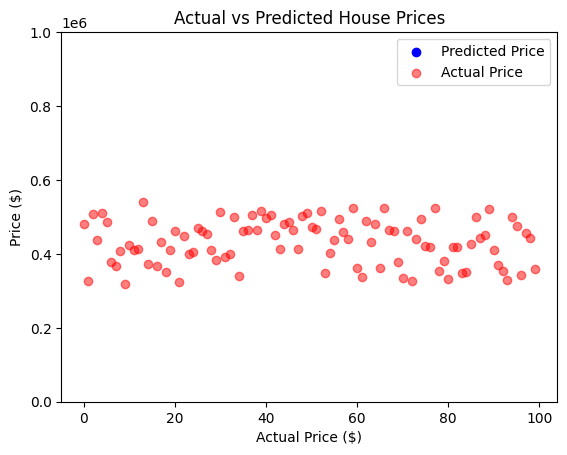

In [31]:
# plt.scatter(for_plot, predicted_price, color='blue', label='Predicted Price')
plt.scatter(for_plot, original_prices, color='red', alpha=0.5, label='Actual Price')
plt.ylim([0, 1000000])
plt.xlabel("Actual Price ($)")
plt.ylabel("Price ($)")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.show()


# STEP BY STEP TUTORIAL OF NEURAL NET

We have training data and simple neural net model, start with initilize neural net model and explain parts that is not clear for me. 

Model parameters is next - SimpleNeuralNet(n_input=2, n_hidden=10, lr=0.001)

In [33]:
n_input = 2
n_hidden = 100
lr = 0.001

In [36]:
layer1 = (torch.rand(n_input, n_hidden) - 0.5) / n_hidden
layer2 = torch.rand(n_hidden, 1) - 0.3
const = torch.rand(1)[0]

*def initialize_grads* 

A call to the method that sets .requires_grad_ to True for all weights and the bias, enabling automatic gradient computation during training.

Applies .requires_grad_() to all parameters (self.layer1, self.layer2, self.const). This is necessary for PyTorch's autograd to compute gradients for backpropagation.

In [37]:
layer1.requires_grad_()
layer2.requires_grad_()
const.requires_grad_()

tensor(0.0028, requires_grad=True)

In [40]:
layer1.shape, layer2.shape

(torch.Size([2, 100]), torch.Size([100, 1]))

**now it is time for training** 

*EPOCH 1*

In [41]:
# FORWARD step
input_data = features # training data
x = F.relu(torch.matmul(input_data, layer1))
output = torch.matmul(x, layer2) + const

In [53]:
# output is one number for each row, so called predicted target
compare_tensor = torch.stack((output, price, price-output), dim=1)
torch.set_printoptions(sci_mode=False)
print(f"SUM OF DIFFERENCES: {compare_tensor[:, 2].sum()}")
compare_tensor

SUM OF DIFFERENCES: 43181216.0


tensor([[[   31.3301],
         [481869.6875],
         [481838.3438]],

        [[   31.2688],
         [326845.7500],
         [326814.4688]],

        [[   33.3063],
         [508371.9688],
         [508338.6562]],

        [[   32.8919],
         [438528.3438],
         [438495.4375]],

        [[   35.7883],
         [511455.8750],
         [511420.0938]],

        [[   35.4345],
         [484949.5625],
         [484914.1250]],

        [[   33.1576],
         [378579.9375],
         [378546.7812]],

        [[   29.0953],
         [367936.7812],
         [367907.6875]],

        [[   34.5987],
         [408399.4375],
         [408364.8438]],

        [[   31.0182],
         [317362.2188],
         [317331.1875]],

        [[   34.6613],
         [424000.6875],
         [423966.0312]],

        [[   34.5668],
         [409624.8125],
         [409590.2500]],

        [[   34.1417],
         [412108.0625],
         [412073.9062]],

        [[   36.6665],
         [539255.6250],
    

SUM OF DIFFERENCES: 43181216.0

this is really huge number, so in first epoch our model is really bad so loss will be bad also

In [56]:
# calculate lose 
loss = F.mse_loss(output, price)
loss

tensor(190027137024., grad_fn=<MseLossBackward0>)

**Zero Gradients**

**What Happens**: Before the network can update its weights, the gradients are reset to zero. This is done by calling self.zero_grads(), which sets the gradients of all parameters to zero.

**Why It's Necessary**: Gradients accumulate by default in PyTorch. If they're not reset to zero before each backward pass, gradients from previous training iterations will interfere, leading to incorrect weight updates.

P.S. in first epoch grads will be zero

In [63]:
for layer in [layer1, layer2]:
    if layer.grad is not None:
        layer.grad.data.zero_()
    if const.grad is not None:
        const.grad.data.zero_()

**Backward Pass**

**What Happens**: The backward pass involves computing the gradient of the loss function with respect to each parameter (weights and biases). This is done by calling loss.backward().

**Why It's Necessary**: The gradients calculated here are used to adjust the weights of the network. They indicate the direction in which each parameter should be adjusted to minimize the loss.

In [64]:
loss.backward()

**Update Weights**

**What Happens**: The weights are updated in the direction that reduces the loss. This is done in self.update_coeffs(), where each parameter is adjusted by subtracting a fraction (defined by the learning rate) of its gradient.

**Why It's Necessary**: Updating the weights is how the network learns. By iteratively adjusting the weights in response to the calculated gradients, the network gradually becomes better at making predictions.

P.S. changes will be zeros because gradients were zeros

In [75]:
print(f"OLD layer {layer1[:, :5]}")
for layer in [layer1, layer2]:
    layer.data.sub_(layer.grad.data * lr)
    layer.grad.data.zero_()
const.data.sub_(const.grad.data * lr)
const.grad.data.zero_()
print(f"new layer {layer1[:, :5]}")

OLD layer tensor([[901773.0625, -17817.4531,     -0.0007, -24691.5039,     -0.0015],
        [  1651.8247,    -32.6406,     -0.0011,    -45.2243,     -0.0038]],
       grad_fn=<SliceBackward0>)
new layer tensor([[901773.0625, -17817.4531,     -0.0007, -24691.5039,     -0.0015],
        [  1651.8247,    -32.6406,     -0.0011,    -45.2243,     -0.0038]],
       grad_fn=<SliceBackward0>)


**Continue training on second epoch**

In [82]:
# FORWARD step
x = F.relu(torch.matmul(input_data, layer1))
output = torch.matmul(x, layer2) + const

compare_tensor = torch.stack((output, price, price-output), dim=1)
torch.set_printoptions(sci_mode=False)
print(f"SUM OF DIFFERENCES: {compare_tensor[:, 2].sum()}")

SUM OF DIFFERENCES: -7772249591382016.0


In [83]:
# calculate lose 
loss = F.mse_loss(output, price)
loss

tensor(6068823552452318142077599744., grad_fn=<MseLossBackward0>)

In [86]:
for layer in [layer1, layer2]:
    if layer.grad is not None:
        layer.grad.data.zero_()
    if const.grad is not None:
        const.grad.data.zero_()

In [88]:
loss.backward()

In [89]:
print(f"OLD layer {layer1[:, :5]}")

OLD layer tensor([[901773.0625, -17817.4531,     -0.0007, -24691.5039,     -0.0015],
        [  1651.8247,    -32.6406,     -0.0011,    -45.2243,     -0.0038]],
       grad_fn=<SliceBackward0>)


In [90]:
for layer in [layer1, layer2]:
    layer.data.sub_(layer.grad.data * lr)
    layer.grad.data.zero_()
const.data.sub_(const.grad.data * lr)
const.grad.data.zero_()
print(f"new layer {layer1[:, :5]}")

new layer tensor([[-163644352831160320.0000, -17817.4531,     -0.0007, -24691.5039,     -0.0015],
        [-283956662501376.0000,    -32.6406,     -0.0011,    -45.2243,     -0.0038]],
       grad_fn=<SliceBackward0>)


**Intuition Behind Training Neural Networks**

The entire process is akin to a feedback system. The network makes predictions, checks how far these predictions are from the truth, and then adjusts itself to improve these predictions in future iterations. This loop of making predictions, evaluating errors, and learning from errors is what makes neural networks capable of learning complex mappings from inputs to outputs.

**Activation Function: ReLU**

What is ReLU: F.relu stands for Rectified Linear Unit, a type of activation function.
How it Works: It simply replaces negative values in its input with zero and keeps positive values as they are (i.e., F.relu(x) = max(0, x)).
Why Use ReLU: It introduces non-linearity to the model, allowing it to learn more complex patterns. Additionally, ReLUs are computationally efficient and help mitigate the vanishing gradient problem, which is common in deep networks.

# deep dive in Backward Pass

The `backward` method in PyTorch, as invoked by `loss.backward()`, is indeed a bit of a deep dive into how automatic differentiation works in neural networks. Here's a simplified explanation:

### Automatic Differentiation and Computational Graphs

When you use PyTorch to build a model, under the hood, it constructs a computational graph. A computational graph is a more abstract representation of the operations performed on tensors; it keeps track of where the data came from and the operations applied to it. 

- **Forward Pass**: During the forward pass (e.g., when computing `output = self.forward(input_data)`), PyTorch builds this graph, and each operation in the network adds a node to this graph. The graph keeps track of the function used (like addition, matrix multiplication, ReLU activation, etc.) and the tensors involved.

- **Loss Calculation**: When you calculate the loss (e.g., `loss = F.mse_loss(output, target_data)`), the loss itself becomes the final node in this computational graph. It's a function of the network's outputs and the actual target values.

### The Backward Pass and Gradients

When you call `loss.backward()`, PyTorch traverses this graph in reverse order, from the loss node back to the input nodes:

1. **Gradient Computation**: PyTorch computes the gradients of the loss with respect to each node in the graph. This is done using the chain rule of calculus. Essentially, for each operation in the graph, PyTorch knows how to compute its gradient, and it uses the chain rule to propagate these gradients back to the input nodes (i.e., the weights and biases).

2. **Backpropagation**: The process of calculating these gradients and passing them back through the network is known as backpropagation. As the gradients are propagated backwards, each parameter (weights and biases) in the network receives the gradient of the loss with respect to itself.

3. **Updating Parameters**: Once the gradients are computed, they are used to update the weights and biases in the direction that minimizes the loss. This update is typically done by subtracting a fraction of the gradient from the current value of each parameter (`self.update_coeffs()` in your class).

### Why Does `loss.backward()` Know About the Weights?

- The connection between the loss and the network's weights is established via the computational graph. When the loss is computed, it's done as a function of the network's output, which in turn is a function of the weights and biases. So, the loss inherently contains information about how it was computed, which includes the weights and biases.
- When `loss.backward()` is executed, it uses this information stored in the computational graph to compute the gradients of the loss with respect to each parameter.

### Intuition

Think of the network as a complex machine where you're adjusting some knobs (weights and biases) to get the right output. The loss function tells you how far off you are from the desired output. The `backward` pass tells you how to turn each knob and by how much to get closer to the desired output. This information is derived from how each knob (parameter) affects the output, which is what the computational graph keeps track of.

Understanding the nuances of backpropagation and automatic differentiation is fundamental to understanding how deep learning models learn from data. This process allows neural networks to adjust their parameters to improve performance iteratively.